<a href="https://colab.research.google.com/github/flydragon2018/colab_notebooks/blob/main/412_happywhale_v2_Inference_b7_fold2_s24_768_newmodel_for_backfin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (In Progress)

### Note: The code is setup in a way that you can easily run the notebook on colab with minimal changes
### TFRecords Dataset: https://www.kaggle.com/ks2019/happywhale-tfrecords-v1
### Code for generating TFRecords: https://www.kaggle.com/ks2019/happywhale-tfrecords

In [1]:
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/mydrive', force_remount=True)
else:
  from kaggle_datasets import KaggleDatasets

True
Mounted at /content/mydrive


In [2]:
#!pip install tfimm
#!pip install timm
#import tfimm
#print(tfimm.list_models(pretrained="timm"))

In [3]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.119.117.26:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.119.117.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.117.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [4]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


## Config

In [60]:
save_dir = '.'
#EXPERIMENT = 0
#EXPERIMENT = 1
EXPERIMENT = 2
#EXPERIMENT = 3
#EXPERIMENT = 4

run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir =  f'/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_256/experiments-{EXPERIMENT}/{run_ts}'
    !mkdir -p {save_dir}

20220412-031319


In [61]:
class config:
    
    
    SEED = 42
    FOLD_TO_RUN = EXPERIMENT
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    #RESUME = True
    #  RESUME_EPOCH = 8
    
    ### Dataset
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 768
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1' #'effnetv1'  
    EFF_NET = 7
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 120
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 100
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [62]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b7


In [63]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [64]:
GCS_PATH = 'gs://kds-aeefb5514f9113922605af8a7639d4ec13f1a7570b85825e9ca42693'  # Get GCS Path from kaggle notebook if GCS Path is expired
if not IS_COLAB:
    GCS_DS_PATH=KaggleDatasets().get_gcs_path('backfintfrecords')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-aeefb5514f9113922605af8a7639d4ec13f1a7570b85825e9ca42693
10 10 41574 27943


## Data

In [65]:
'''
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
# Updated to include crops.
def decode_image(image_data, box):
    if box is not None and box[0] != -1:
        left, top, right, bottom = box[0], box[1], box[2], box[3]
        bbs = tf.convert_to_tensor([top, left, bottom - top, right - left])
        image = tf.io.decode_and_crop_jpeg(image_data, bbs, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels = 3)

    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
        'detic_box': tf.io.FixedLenFeature([4], tf.int64),
         # 'yolov5_box': tf.io.FixedLenFeature([4], tf.int64),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    bb = tf.cast(example['detic_box'], tf.int32)
    image = decode_image(example['image'], bb)
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

  '''

'\ndef arcface_format(posting_id, image, label_group, matches):\n    return posting_id, {\'inp1\': image, \'inp2\': label_group}, label_group, matches\n\ndef arcface_inference_format(posting_id, image, label_group, matches):\n    return image,posting_id\n\ndef arcface_eval_format(posting_id, image, label_group, matches):\n    return image,label_group\n\n# Data augmentation function\ndef data_augment(posting_id, image, label_group, matches):\n\n    ### CUTOUT\n    if tf.random.uniform([])>0.5 and config.CUTOUT:\n      N_CUTOUT = 6\n      for cutouts in range(N_CUTOUT):\n        if tf.random.uniform([])>0.5:\n           DIM = config.IMAGE_SIZE\n           CUTOUT_LENGTH = DIM//8\n           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)\n           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)\n           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)\n 

In [66]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

41574


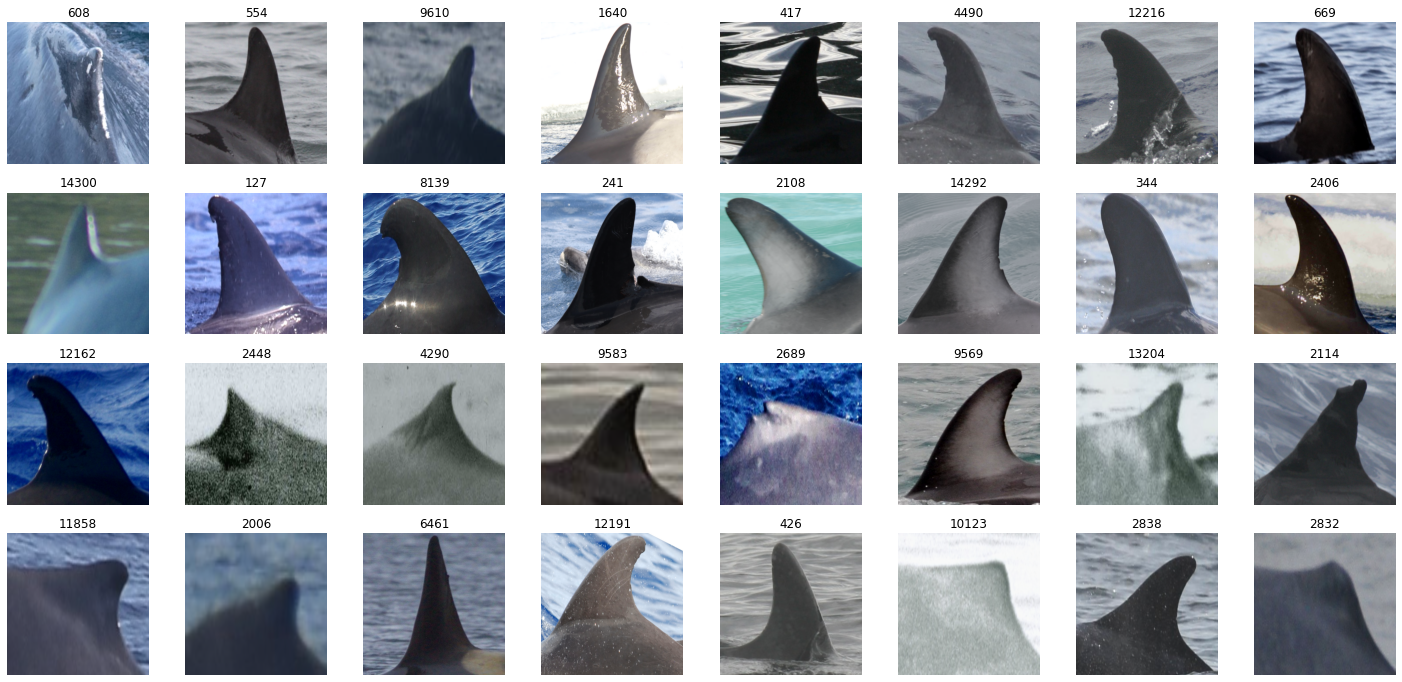

(32, 768, 768, 3)


In [67]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

27943


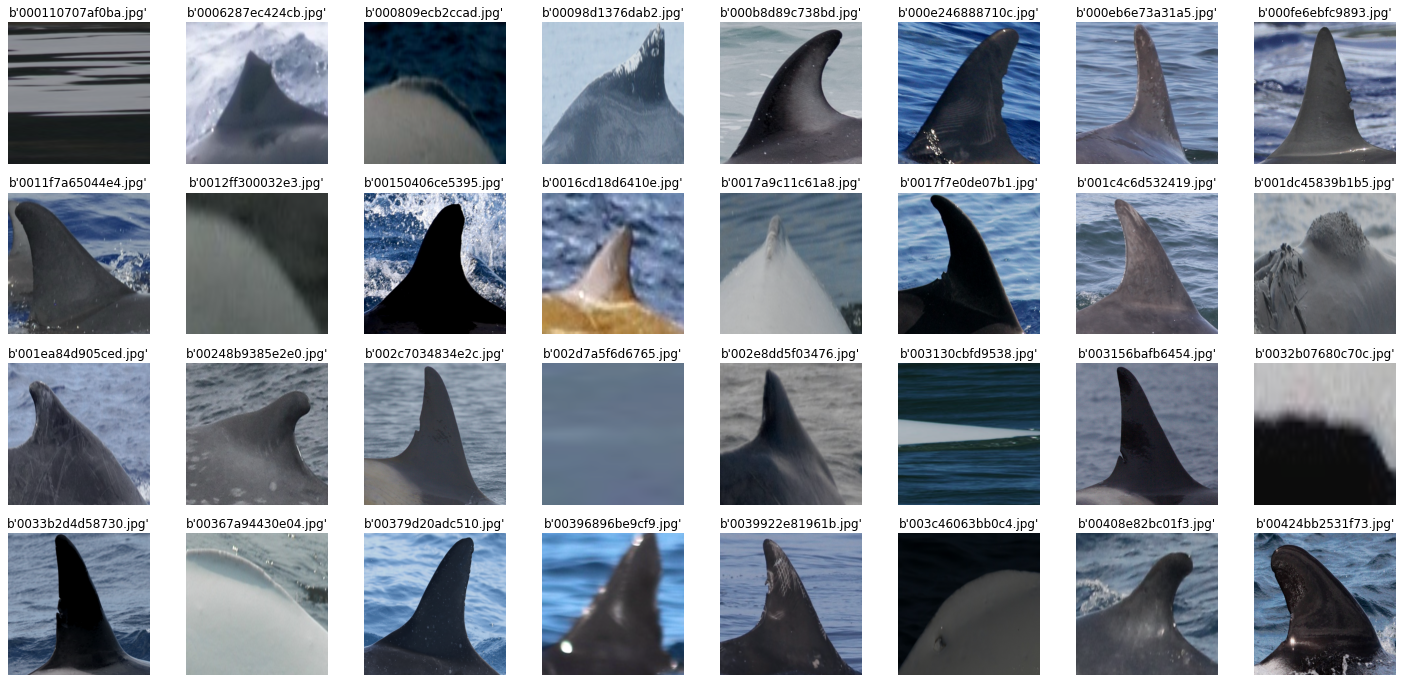

(32, 768, 768, 3)


In [68]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

## Model

In [69]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [70]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'
else:
    MODEL_NAME = config.model_type
config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b7


In [71]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]
#from classification_models.keras import Classifiers
#model, preprocess_input = Classifiers.get('resnet34')
def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            #s = 30, 
            s=24,
            #m = 0.3, 
            m = 0.3,
            name=f'head/{config.head}', 
            dtype='float32'
            )

        #inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        #x1 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-1].output)  #-3,-7,-9,-15  for EF5    
        #x2 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-3].output) # 803,799,797,791 for EF7
        #x =  tf.concat([x1,x3,x5],axis = 1)
        if config.model_type == 'effnetv1':
            inp = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False,input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])
            inp.layers[0]._name = 'inp1'
            #inp.summary()
            x1=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-1].output)

            x2=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-5].output)
            x3=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-7].output)
            x4=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-13].output)
            embed =  tf.concat([x1,x2,x3,x4],axis = 1)
            #embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
        else:
            embed = tfimm.create_model(config.MODEL_NAME, pretrained="timm")(inp)
            #embed = tf.keras.layers.GlobalAveragePooling2D()(x)

        embed = tf.keras.layers.Dropout(0.3)(embed)
        embed = tf.keras.layers.Dense(2048)(embed)
        #embed = tf.keras.layers.Dropout(0.2)(embed)
        #embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp.input, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp.input, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

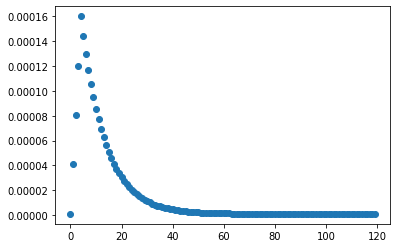

In [72]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [73]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Train

In [74]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 33259 8315


In [75]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [76]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.model_type}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
#model.summary()

#config.RESUME=True
#config.RESUME_EPOCH = 18
#if config.RESUME:   
    #model.load_weights('/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-0/20220308-113905/effnetv1_loss_0.h5')
#    model.load_weights('/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-0/20220308-165005/effnetv1_b7_last.h5')


In [77]:
import gc
gc.collect()

6511

In [78]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))
'''
history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)
'''

#### Image Size 768 with EfficientNet B7 and batch_size 32


'\nhistory = model.fit(train_dataset,\n                validation_data = val_dataset,\n                steps_per_epoch = STEPS_PER_EPOCH,\n                epochs = config.EPOCHS,\n                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], \n                verbose = VERBOSE)\n'

In [79]:
#model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5")

In [80]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-0/20220308-165005/effnetv1_loss_0.h5")

In [81]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-2/20220310-042039/effnetv1_loss_2.h5")

In [82]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-3/20220311-050553/effnetv1_loss_3.h5")

In [83]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-4/20220312-044053/effnetv1_loss_4.h5")

In [84]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-0/20220312-170404/effnetv1_loss_0.h5")

In [85]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-1/20220313-053240/effnetv1_loss_1.h5")

In [86]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/b7_768/experiments-2/20220313-193200/effnetv1_loss_2.h5")

In [87]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_256/experiments-0/20220401-093048/effnetv1_loss_0.h5")

In [88]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_512/experiments-0/20220402-054441/effnetv1_loss_0.h5")

In [89]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_512/experiments-0/20220402-152057/effnetv1_loss_0.h5")

In [90]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_768/experiments-1/20220408-050755/effnetv1_loss_1.h5")

In [91]:
#model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_768/experiments-1/20220409-063100/effnetv1_loss_1.h5")

In [92]:
model.load_weights("/content/mydrive/MyDrive/kaggle/backfin_newmodel/v2/b7_768/experiments-2/20220411-142935/effnetv1_loss_2.h5")

## Evaluation

In [93]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ("/content/mydrive/MyDrive/individual_ids.json", "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [94]:
train_targets = []
train_embeddings = []
train_data_list=[] 

for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'train_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings)    
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
    train_data_list.append([filename,embeddings])
train_embeddings_df = pd.DataFrame(train_data_list, columns=['filename', 'embeddings'])
train_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
train_embeddings_df.to_csv(config.save_dir+f"/train_embeddings_{config.FOLD_TO_RUN}.csv",index=False)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/8 [00:00<?, ?it/s]

In [95]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [96]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
val_data_list=[] 
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'val_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings) 
    val_data_list.append([filename,embeddings])
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
val_embeddings_df = pd.DataFrame(val_data_list, columns=['filename', 'embeddings'])
val_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
val_embeddings_df.to_csv(config.save_dir+f"/val_embeddings_{config.FOLD_TO_RUN}.csv",index=False)

test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/2 [00:00<?, ?it/s]

In [97]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    1903
37c7aba965a5        81
c995c043c353        44
bc1eb2241633        41
114207cab555        36
                  ... 
dfee3826785c         1
d5f10b4c63b4         1
abbbd4acd487         1
7f4cf70f38f6         1
73e7dd60e2f7         1
Name: target, Length: 2613, dtype: int64

In [98]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/8315 [00:00<?, ?it/s]

1      527
14     203
13     202
15     193
12     189
      ... 
93       5
97       2
99       2
96       2
100      1
Name: image, Length: 100, dtype: int64

In [99]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.0: 0.7620485067147705


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.1: 0.7620485067147705


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.2: 0.7620485067147705


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.7622289035878914


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.4: 0.7843575866907175


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.5: 0.8363720184405667


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.8438885548206028


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.8227821206654616


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.8: 0.7820725596311866


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 0.9: 0.7147845259571041


0it [00:00, ?it/s]

  0%|          | 0/8315 [00:00<?, ?it/s]

CV at threshold 1.0: 0.5586810984165164


In [100]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.6000000000000001
Best cv 0.8438885548206028


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
count,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000,8315.000000
mean,0.762049,0.762049,0.762049,0.762229,0.784358,0.836372,0.843889,0.822782,0.782073,0.714785,0.558681
std,0.340176,0.340176,0.340176,0.340170,0.338651,0.329248,0.327183,0.332516,0.338875,0.338563,0.281527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 6412, True: 1903}
best_threshold 0.5


is_new_individual,False,True,adjusted_cv
0.0,0.839821,0.500000,0.805839
0.1,0.839821,0.500000,0.805839
0.2,0.839821,0.500000,0.805839
0.30000000000000004,0.839821,0.500788,0.805918
0.4,0.839353,0.599054,0.815323
0.5,0.831711,0.852076,0.833748
0.6000000000000001,0.808240,0.964004,0.823816
0.7000000000000001,0.773227,0.989753,0.794880
0.8,0.718174,0.997373,0.746094
0.9,0.630604,0.998424,0.667386


## Inference

In [102]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(41574, 2048) (41574,)


In [103]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [104]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
test_data_list=[] 
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'test_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings) 
    test_data_list.append([filename,embeddings])
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)

test_embeddings_df = pd.DataFrame(test_data_list, columns=['filename', 'embeddings'])
test_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
test_embeddings_df.to_csv(config.save_dir+f"/test_embeddings_{config.FOLD_TO_RUN}.csv",index=False)



test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [105]:
sample_submission = pd.read_csv("/content/mydrive/MyDrive/kaggle/backfin/sample_submission.csv",index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27942 27956


  0%|          | 0/27942 [00:00<?, ?it/s]

1      686
15     615
19     612
20     611
18     607
      ... 
94      22
97      20
98      19
99       7
100      4
Name: image, Length: 100, dtype: int64

In [106]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [107]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(config.save_dir+f"/submission.csv",index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27942 [00:00<?, ?it/s]

,image,predictions
0,a3f60cad2aae2d.jpg,e8ac23241df5 new_individual 2c6dd2efff3b 5652d...
1,55a08e016c4f3f.jpg,5f2296c18e26 new_individual 1ca27588a1f7 abbeb...
2,eff6a14b8602cd.jpg,abbeba14a290 new_individual 5e4ac2797f3e aa169...
3,8787dd833b058b.jpg,abbeba14a290 new_individual 5e4ac2797f3e aa169...
4,1e2985de58a097.jpg,3f483882f6a0 new_individual daf85f810f28 5eb72...


In [108]:
predictions.to_csv("submission.csv",index=False)

drop the images which do not have a backfin & fill these predictions with a general model such as from:

In [109]:
df2 = pd.read_csv("/content/mydrive/MyDrive/kaggle/submission_ens_v2_730.csv")
#df2 = pd.read_csv("/content/mydrive/MyDrive/kaggle/submission766.csv")

ids = np.load("/content/mydrive/MyDrive/kaggle/ids_without_backfin.npy", allow_pickle = True) #whales without backfins determined with a simple classifier

In [110]:
ids2 = df2["image"][~df2["image"].isin(predictions["image"])] #images without a bounding box

In [111]:
submission = pd.concat([
    predictions[~(predictions["image"].isin(ids))],
    df2[df2["image"].isin(ids)],
    df2[df2["image"].isin(ids2)]
])

In [112]:
submission = submission.drop_duplicates()

In [115]:
submission.to_csv('412submission_backfin_newmodel_fold2_768_v2.csv',index=False)
submission.head()

,image,predictions
0,a3f60cad2aae2d.jpg,e8ac23241df5 new_individual 2c6dd2efff3b 5652d...
1,55a08e016c4f3f.jpg,5f2296c18e26 new_individual 1ca27588a1f7 abbeb...
2,eff6a14b8602cd.jpg,abbeba14a290 new_individual 5e4ac2797f3e aa169...
3,8787dd833b058b.jpg,abbeba14a290 new_individual 5e4ac2797f3e aa169...
4,1e2985de58a097.jpg,3f483882f6a0 new_individual daf85f810f28 5eb72...
